In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [3]:
import seaborn as sns

### Loading  & cleaning results data

In [4]:
wmt19_results = pd.read_csv('./evaluate/all_wmt19_results_091620.csv')
wmt19_results.method = wmt19_results.method.str.replace('baseline', 'sentencepiece')

In [5]:
segmentation_methods = set(wmt19_results.method.unique()).union({'morsel'})

In [6]:
segmentation_methods

{'lmvr-tuned', 'morsel', 'sentencepiece', 'subword-nmt'}

In [7]:
flores_full = pd.read_csv('./evaluate/all_results_091320.csv')
flores_full.method = flores_full.method.str.replace('baseline-fp16', 'sentencepiece')

In [8]:
flores_results = flores_full[flores_full.method.isin(segmentation_methods)].copy()

In [9]:
combined_results = pd.concat([flores_results, wmt19_results], ignore_index=True).copy()

In [10]:
combined_results['chrf3'] = 100*combined_results.chrf3
# combined_results['bleu'] = 0.01*combined_results.bleu

In [11]:
combined_results.groupby(['pair'])[['bleu', 'chrf3']].median()

,bleu,chrf3
pair,,
en-gu,0.00,1.50
en-kk,0.65,20.70
en-ne,4.40,31.20
en-si,1.05,27.50
gu-en,0.00,4.30
kk-en,1.95,24.05
ne-en,8.05,32.20
si-en,7.60,32.50


### Exploratory analysis with plots

#### Overall BLEU

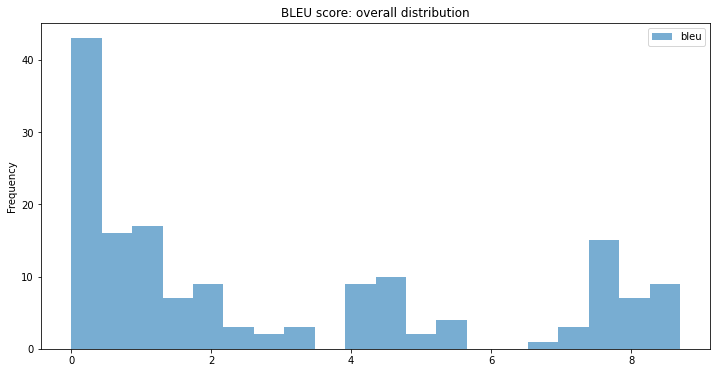

In [12]:
t = 'BLEU score: overall distribution'
combined_results\
    .bleu.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               bins=20, legend=True)

Definitely seems like a multimodal distribution, with possible zero-inflation.

#### Overall CHRF3

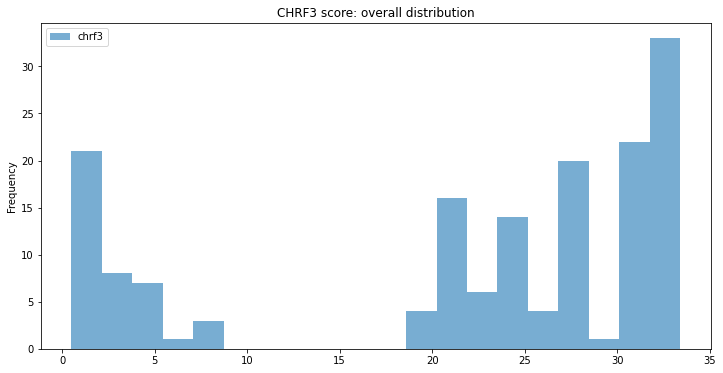

In [13]:
t = 'CHRF3 score: overall distribution'
combined_results\
    .chrf3.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               bins=20, legend=True)

#### BLEU vs CHRF3

Text(0.5, 1.0, 'BLEU vs. CHRF3')

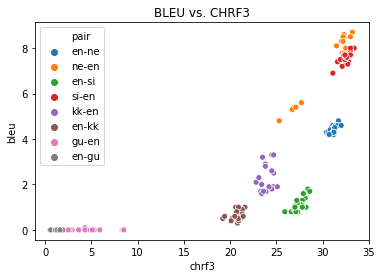

In [14]:
ax = sns.scatterplot(x=combined_results.chrf3, 
                     y=combined_results.bleu, 
                     hue=combined_results.pair)
plt.title("BLEU vs. CHRF3")

pair
en-gu    AxesSubplot(0.125,0.125;0.775x0.755)
en-kk    AxesSubplot(0.125,0.125;0.775x0.755)
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
gu-en    AxesSubplot(0.125,0.125;0.775x0.755)
kk-en    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

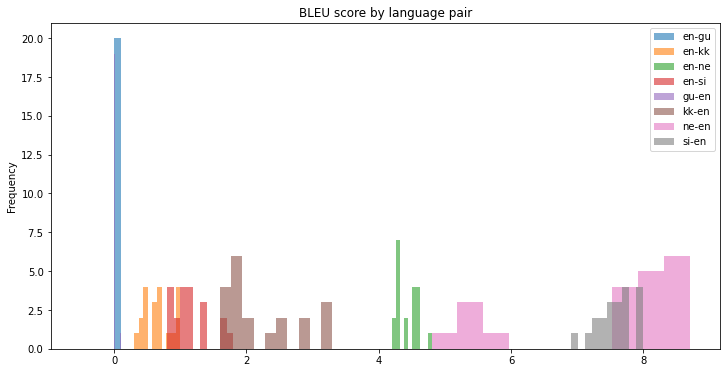

In [15]:
t = 'BLEU score by language pair'
combined_results\
    .groupby(['pair'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True)

pair
en-gu    AxesSubplot(0.125,0.125;0.775x0.755)
en-kk    AxesSubplot(0.125,0.125;0.775x0.755)
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
gu-en    AxesSubplot(0.125,0.125;0.775x0.755)
kk-en    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: chrf3, dtype: object

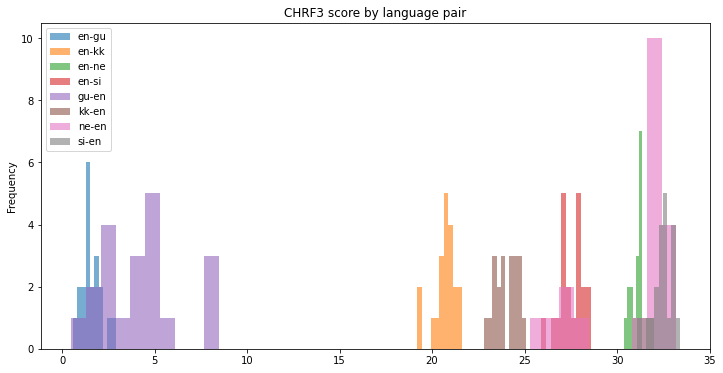

In [16]:
t = 'CHRF3 score by language pair'
combined_results\
    .groupby(['pair'])\
    .chrf3.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True)

### How do things vary by segmentation method?

We can include information about both the language pair and segmentation method in a scatterplot:

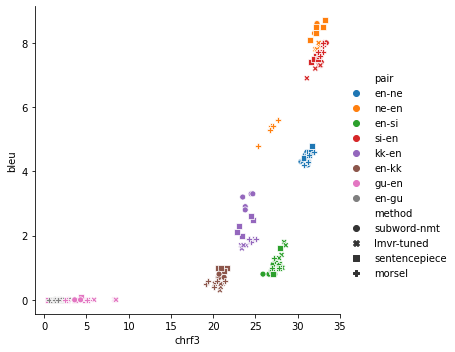

In [17]:
sns.relplot(x="chrf3", 
            y="bleu", 
            hue="pair", 
            style="method", 
            data=combined_results)

In [18]:
def posterior_predictive_check(obs, posterior_pred, metric_name='bleu', n_bins=30):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism[f'{metric_name}_fake'] = posterior_pred[f'{metric_name}_observed'][rand_ix]
    criticism[f'{metric_name}_observed'] = obs
    criticism.plot(kind='hist', alpha=0.7, title=f'Posterior predictive check: {metric_name}', figsize=(12,6), bins=n_bins)

### Comparison against `subword-nmt`

In [19]:
def compare_to_baseline(results, baseline_method='sentencepiece'):
    """
    Creates a dictionary of seed-by-seed comparisons
    to a baseline for each language pair and model
    """
    language_pairs = set(results.pair.unique())
    segmentation_methods = set(results.method.unique())
    output = pd.DataFrame()
    for lang_pair in language_pairs:
        lang_pair_rows = results[results.pair == lang_pair].copy()
        baseline = lang_pair_rows[lang_pair_rows.method == baseline_method].set_index('seed')
        for method in segmentation_methods:
            if method == baseline_method:
                continue
            method_rows = lang_pair_rows[lang_pair_rows.method == method].set_index('seed')
            diff = method_rows[['bleu', 'chrf3']] - baseline[['bleu', 'chrf3']]
            diff['segm_method'] = method
            diff['lang_pair'] = lang_pair
            output = pd.concat([output, diff])

    return output

In [20]:
baseline_comparisons = compare_to_baseline(combined_results, 
                                           baseline_method='subword-nmt')

In [21]:
baseline_comparisons.groupby('segm_method').bleu.describe()

,count,mean,std,min,25%,50%,75%,max
segm_method,,,,,,,,
lmvr-tuned,40.0,-0.2950,0.583073,-1.6,-0.525,-0.20,0.0,1.0
morsel,40.0,-0.5425,1.103116,-3.7,-0.450,-0.05,0.0,0.4
sentencepiece,40.0,-0.0550,0.377543,-1.0,-0.225,0.00,0.2,0.8


In [22]:
baseline_comparisons.groupby('segm_method').chrf3.describe()

,count,mean,std,min,25%,50%,75%,max
segm_method,,,,,,,,
lmvr-tuned,40.0,0.7125,1.726890,-2.0,-0.125,0.20,0.95,6.6
morsel,40.0,-0.4750,2.119960,-7.0,-0.500,0.05,0.70,3.2
sentencepiece,40.0,0.1000,0.904689,-2.4,-0.400,0.10,0.65,2.3


However these averages don't tell the full story. We can also group by both the language pair and segmentation method and inspect the median: 

In [23]:
baseline_comparisons.groupby(['lang_pair', 'segm_method']).bleu.describe()[['min', '50%', 'max']]

min  50%  max
lang_pair segm_method                 
en-gu     lmvr-tuned     0.0  0.0  0.0
          morsel         0.0  0.0  0.0
          sentencepiece  0.0  0.0  0.0
en-kk     lmvr-tuned    -0.4 -0.3 -0.2
          morsel        -0.3 -0.2 -0.1
          sentencepiece  0.1  0.3  0.3
en-ne     lmvr-tuned    -0.3 -0.2  0.1
          morsel        -0.3 -0.1  0.3
          sentencepiece -0.1  0.2  0.3
en-si     lmvr-tuned    -0.1  0.6  1.0
          morsel        -0.1  0.3  0.4
          sentencepiece -0.3  0.2  0.8
gu-en     lmvr-tuned     0.0  0.0  0.0
          morsel         0.0  0.0  0.0
          sentencepiece  0.0  0.0  0.1
kk-en     lmvr-tuned    -1.6 -1.5 -1.1
          morsel        -1.5 -1.3 -0.9
          sentencepiece -1.0 -0.7 -0.7
ne-en     lmvr-tuned    -0.7 -0.6 -0.5
          morsel        -3.7 -3.2 -2.7
          sentencepiece -0.5 -0.1  0.4
si-en     lmvr-tuned    -1.1 -0.4 -0.2
          morsel        -0.3  0.0  0.2
          sentencepiece -0.4 -0.3  0.1

In [24]:
baseline_comparisons.groupby(['lang_pair', 'segm_method']).chrf3.describe()[['min', '50%', 'max']]

min  50%  max
lang_pair segm_method                 
en-gu     lmvr-tuned     0.6  0.6  1.6
          morsel        -0.8 -0.1  0.3
          sentencepiece -0.3  0.2  0.4
en-kk     lmvr-tuned    -1.1  0.2  0.5
          morsel        -1.9 -0.5  0.7
          sentencepiece -0.4  0.1  0.9
en-ne     lmvr-tuned    -0.5 -0.1  0.8
          morsel         0.1  0.2  0.8
          sentencepiece -0.4  0.2  1.2
en-si     lmvr-tuned     0.9  1.3  2.5
          morsel        -0.3  0.7  1.4
          sentencepiece  0.0  0.5  2.0
gu-en     lmvr-tuned     2.3  4.0  6.6
          morsel        -0.4  1.0  3.2
          sentencepiece -2.4  0.5  2.3
kk-en     lmvr-tuned    -0.6 -0.3 -0.1
          morsel        -0.5  0.5  1.3
          sentencepiece -1.6 -0.4  1.2
ne-en     lmvr-tuned    -0.1  0.2  0.3
          morsel        -7.0 -5.3 -4.5
          sentencepiece -0.8 -0.1  1.0
si-en     lmvr-tuned    -2.0 -0.7  0.3
          morsel        -1.0 -0.1  0.6
          sentencepiece -1.1 -0.9 -0.4

As we can see it's not completely clear whether the "true" differences would be 0 or not. 

In [49]:
s="EN-NE, NE-EN, EN-SI, SI-EN, EN-KK, KK-EN, EN-GU, GU-EN"
print(s.lower())

en-ne, ne-en, en-si, si-en, en-kk, kk-en, en-gu, gu-en


### Regression models for BLEU and CHRF3 

We can fit the following simple linear model that treats the performance metric, i.e. BLEU or CHRF3, as being a noisy sum of a "language pair" effect, and a "segmentation method" effect.

Our objective is to disentangle the effects of different segmentation methods from the language pair effects.

Mathematically, our model is:

$$
\phi_{lm} = \eta_l + \tau_m + \epsilon_l
$$

where $\phi_{lm} \in \{\text{BLEU, CHRF3}\}$, $l \in \{\text{en-ne, ne-en, en-si, si-en, en-kk, kk-en, en-gu, gu-en}\}$ and $m \in \{\text{sentencepiece, lmvr, morsel, subword-nmt}\}$ and $\epsilon_l$ is a language pair specific variance term.

### BLEU model

For the BLEU model, we exclude Gujarati since the Wikititles corpus produced only 0.0 BLEU scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(4,3)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the BLEU scores, whereas there is no reason to assume that a segmentation method effect exists.

In [25]:
combined_results_sans_gu = combined_results[~combined_results.pair.str.contains('gu')].copy()

In [26]:
def fit_bleu_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 1}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 1}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    
    bleu_observations = observed_data.bleu
    
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('sentencepiece - subword-nmt', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('lmvr-tuned - subword-nmt', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('morsel - subword-nmt', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                 mu=b,
                                 sigma=eps,
                                 observed=bleu_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [27]:
(bleu_model_a, 
 prior_bleu_a, 
 posterior_bleu_a, 
 posterior_pred_bleu_a, 
 bleu_lang_pair_encoder, 
 bleu_segm_method_encoder) = fit_bleu_normal_model(combined_results_sans_gu, 
                                           LabelEncoder(), 
                                           LabelEncoder(), 
                                           eta_params={'mu': 4, 'sigma': 3},
                                           tau_params={'mu': 0, 'sigma': 1},
                                           tune=2000, n=2000, target_accept=0.99,
                                           init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 168 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


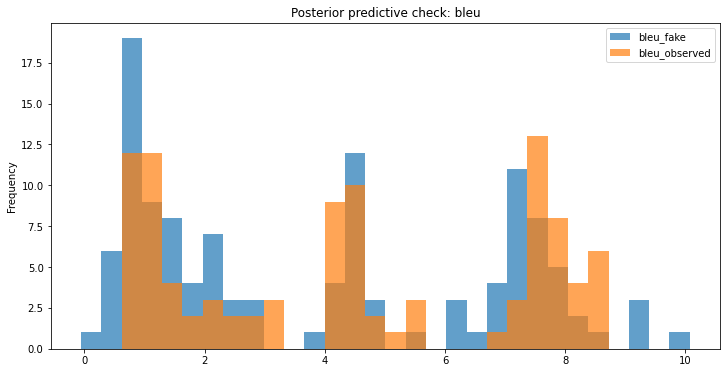

In [28]:
posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_a)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8441545d0>],
      dtype=object)

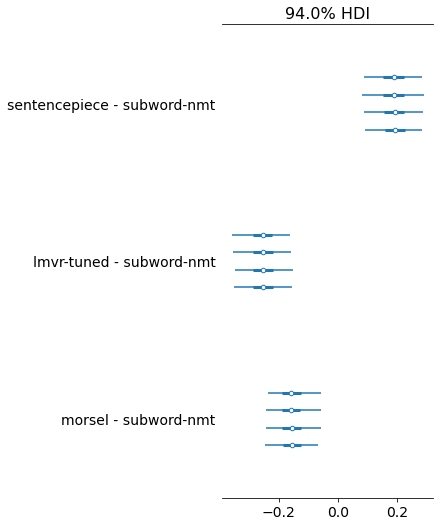

In [29]:
pm.forestplot(posterior_bleu_a, var_names='.*subword-nmt', filter_vars='regex')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb844079910>],
      dtype=object)

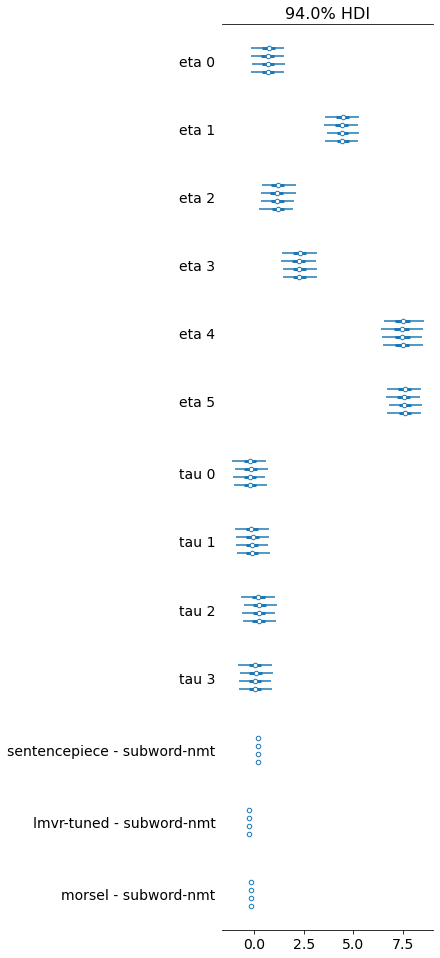

In [30]:
pm.forestplot(posterior_bleu_a, var_names="~noise")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb844331550>],
      dtype=object)

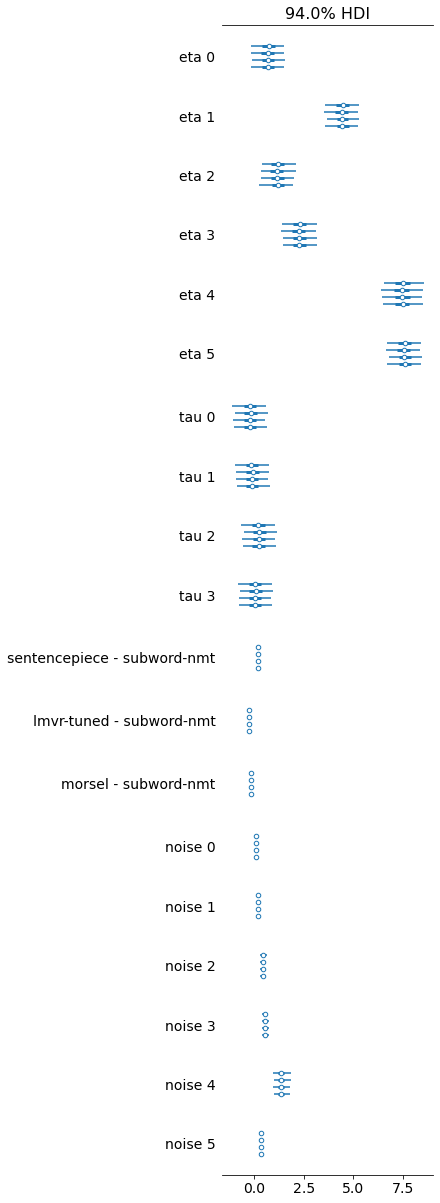

In [31]:
pm.forestplot(posterior_bleu_a)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb846e80910>,
      dtype=object)

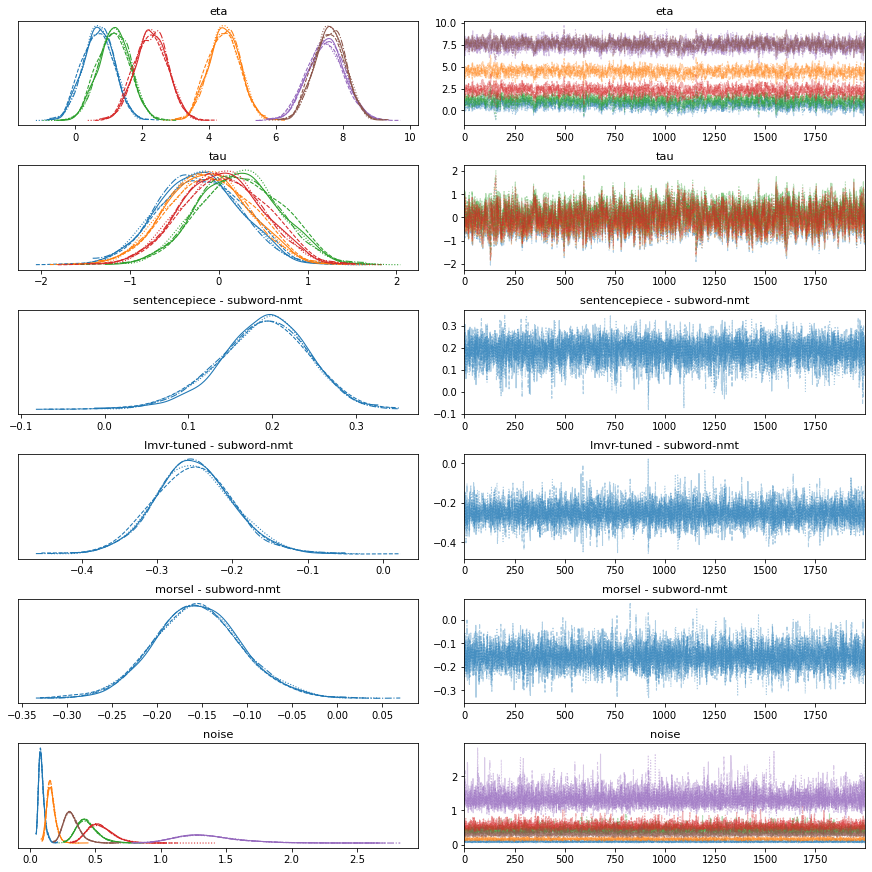

In [32]:
pm.traceplot(posterior_bleu_a)

In [35]:
median_bleu_by_lang_pair = combined_results.groupby('pair').bleu.median().to_dict()

In [36]:
median_bleu_df = pd.DataFrame()
median_bleu_df['lang_pair'] = pd.Series(bleu_lang_pair_encoder.inverse_transform(range(6)))
median_bleu_df['median_bleu'] = pd.Series(bleu_lang_pair_encoder.inverse_transform(range(6))).apply(lambda pair: median_bleu_by_lang_pair[pair])

In [38]:
median_bleu_df

,lang_pair,median_bleu
0,en-kk,0.65
1,en-ne,4.40
2,en-si,1.05
3,kk-en,1.95
4,ne-en,8.05
5,si-en,7.60


### CHRF3 model

For the chrf3 model, we exclude Gujarati since the Wikititles corpus produced only 0.0 chrf3 scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(15, 7)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the chrf3 scores, whereas there is no reason to assume that a segmentation method effect exists.

In [39]:
def fit_chrf3_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 10}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 10}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    chrf3_observations = observed_data.chrf3
    
    chrf3_model = pm.Model()
    with chrf3_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('sentencepiece - subword-nmt', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('lmvr-tuned - subword-nmt', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('morsel - subword-nmt', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=chrf3_observations)
        
        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [40]:
(chrf3_model_a, 
 prior_chrf3_a, 
 posterior_chrf3_a, 
 posterior_pred_chrf3_a, 
 chrf3_lang_pair_encoder, 
 chrf3_segm_method_encoder) = fit_chrf3_normal_model(combined_results, 
                                                  LabelEncoder(), 
                                                  LabelEncoder(),
                                                  eta_params={'mu': 15, 'sigma': 7},
                                                  tau_params={'mu': 0, 'sigma': 1},
                                                  tune=2000, n=2000, 
                                                  target_accept=0.9,
                                                  init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


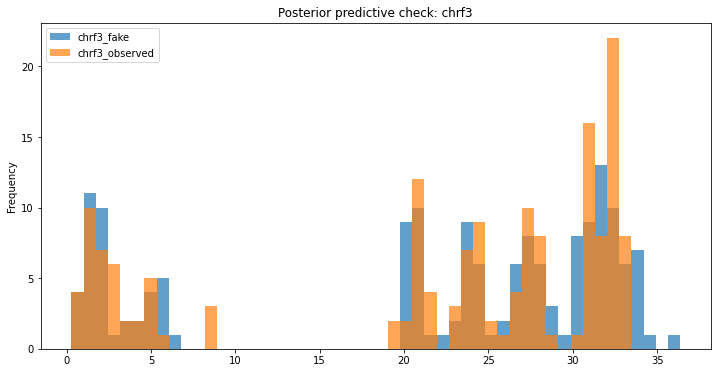

In [41]:
posterior_predictive_check(combined_results.chrf3, posterior_pred_chrf3_a, metric_name="chrf3", n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb82e4955d0>,
      dtype=object)

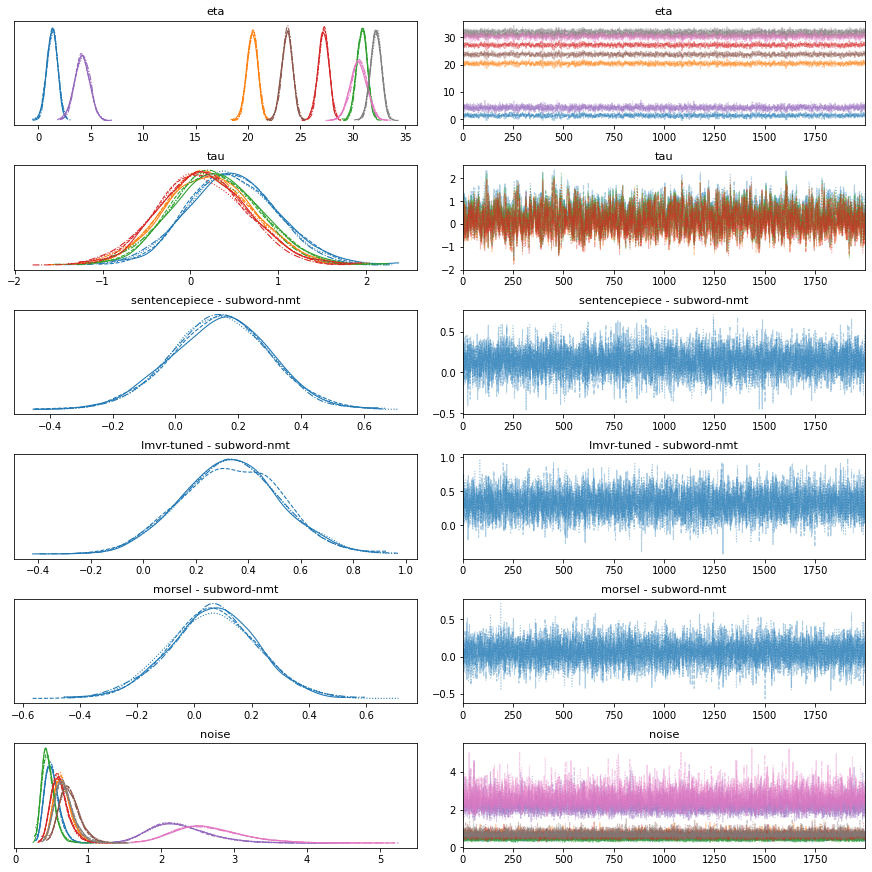

In [42]:
pm.traceplot(posterior_chrf3_a)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb822407a90>],
      dtype=object)

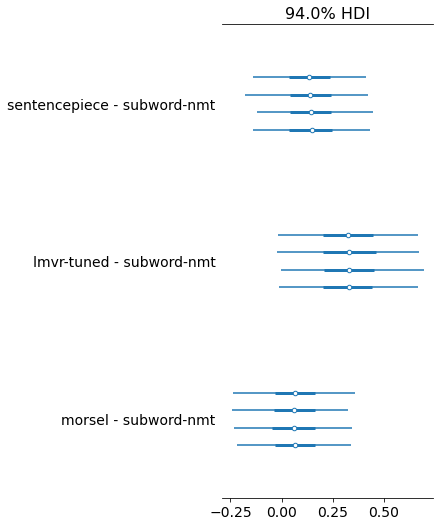

In [43]:
pm.forestplot(posterior_chrf3_a, var_names='.*subword-nmt', filter_vars='regex')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb82e507bd0>],
      dtype=object)

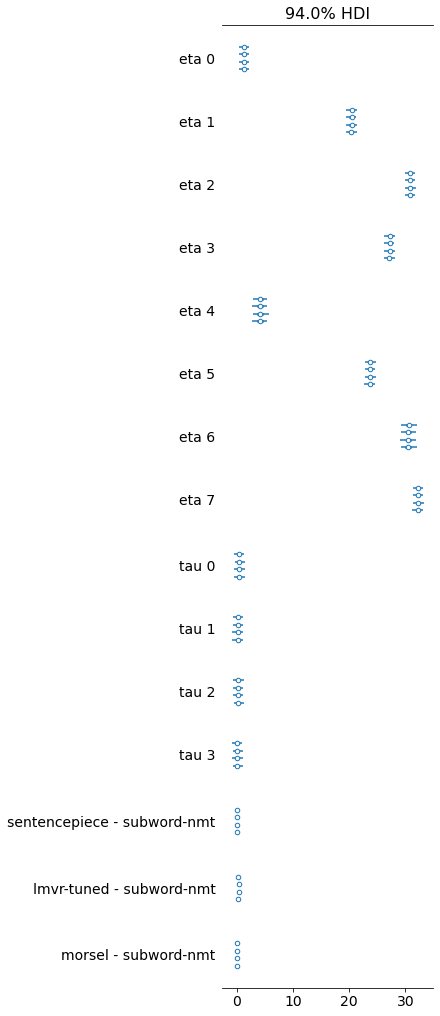

In [44]:
pm.forestplot(posterior_chrf3_a, var_names="~noise")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb821712650>],
      dtype=object)

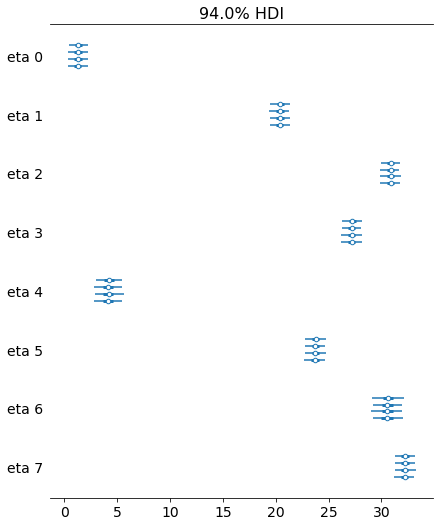

In [45]:
pm.forestplot(posterior_chrf3_a, var_names="eta")

In [46]:
median_chrf3_by_lang_pair = combined_results.groupby('pair').chrf3.median().to_dict()

In [47]:
median_chrf3_df = pd.DataFrame()
median_chrf3_df['lang_pair'] = pd.Series(chrf3_lang_pair_encoder.inverse_transform(range(8)))
median_chrf3_df['median_chrf3'] = pd.Series(chrf3_lang_pair_encoder.inverse_transform(range(8))).apply(lambda pair: median_chrf3_by_lang_pair[pair])

In [48]:
median_chrf3_df

,lang_pair,median_chrf3
0,en-gu,1.50
1,en-kk,20.70
2,en-ne,31.20
3,en-si,27.50
4,gu-en,4.30
5,kk-en,24.05
6,ne-en,32.20
7,si-en,32.50
